In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from graphviz import Digraph

In [6]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        # Unique ID for each node
        uid = str(id(n))
        # Node for value
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        # Node for operation (if exists)
        if n._op:
            op_uid = uid + n._op
            dot.node(name=op_uid, label=n._op, shape="circle")
            dot.edge(op_uid, uid)
    
    # Edges between nodes
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op if n2._op else str(id(n2)))
    
    return dot

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only float and int"
        out = Value(self.data ** other, (self,), f"**{other}")
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out 
        
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __neg__(self): #-self
        return self * -1

    def __sub__(self,other):
        return self + (-other)
        
    def __truediv__(self,other):
        return self * other**-1
        
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __rmul__(self,other):
        return self*other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ),'exp')

        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tahn')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()
    
            

In [8]:
a= Value(4)
b= Value(5)
a - b
# a * 1/b
# a * a**-1

Value(data=-1)

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label= 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label='e'
d = e +c; d.label='d'
f = Value(-2.0, label='f')
L= d*f; L.label='L'

In [10]:
# L = d * f
# dL/dd = ???
# f(x+h) - f(x) / h
# (d+h)*f - d*f / h
# d*f + h*f - d*f / h
# h*f /h
# f

# L = d * f
# dL/dL = 1
# dL/dd = f
# dL/df = d

# ==== chai rule
# d = e + c
# dL/de = (dL/dd) * (dd/de)
# dL/dc = (dL/dd) * (dd/dc)
# e = b * a
# dL/db = (dL/de) * (de/db)
# dL/da = (dL/de) * (de/da)

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2

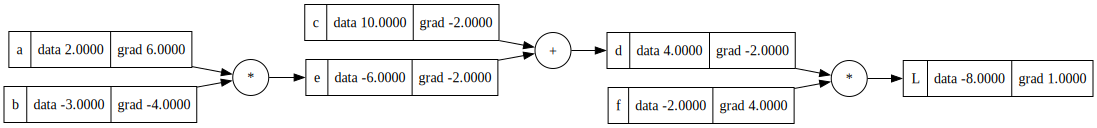

In [11]:
draw_dot(L)

In [12]:
L.grad=1

In [13]:
L._backward()
d._backward()
e._backward()

In [14]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
    
e = a * b
d = e + c
L= d * f
    

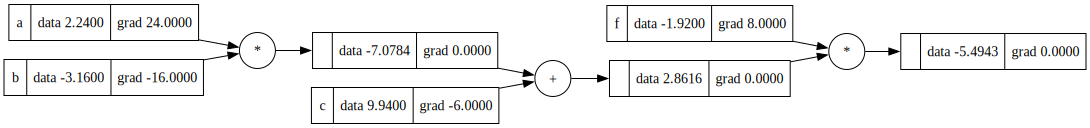

In [15]:
draw_dot(L)

In [16]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label= 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label='e'
    d = e +c; d.label='d'
    f = Value(-2.0, label='f')
    L= d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label= 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label='e'
    d = e +c; d.label='d'
    f = Value(-2.0, label='f')
    L= d*f; L.label='L'
    L2 = L.data + h

    # L= a*b + c * f
    print(f"{L1} | {L2:.4f}")
    print(f"{(L2 - L1) / h}")

In [17]:
x1 = Value(2.0) ; x1.label= 'x1'
x2 = Value(0.0) ; x2.label= 'x2'
w1 = Value(-3.0) ; w1.label= 'w1'
w2 = Value(1.0) ; w2.label= 'w2'
b = Value(6.888881) ; b.label= 'b'
x1w1 = x1*w1 ; x1w1.label= 'x1w1'
x2w2 = x2*w2 ; x2w2.label= 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label= 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label= 'n'
o= n.tanh() ; o.label= 'o'


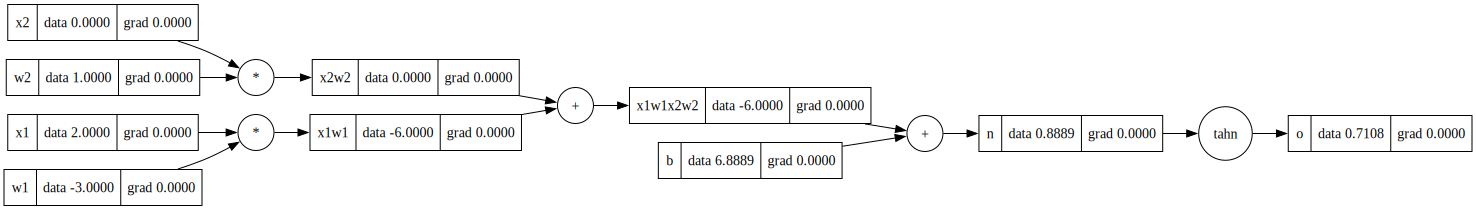

In [18]:
draw_dot(o)

In [19]:
o.backward()

In [20]:
o.grad = 1.0
# o = tahn(n)
# do/dn = 1- o**2
n.grad = 1 - o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
# x2w2 = w2 *x2
# do/dw2 = do/x2w2 * d2w2/x2
# do/dw2 = x2w2.grad * x2.data
w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data

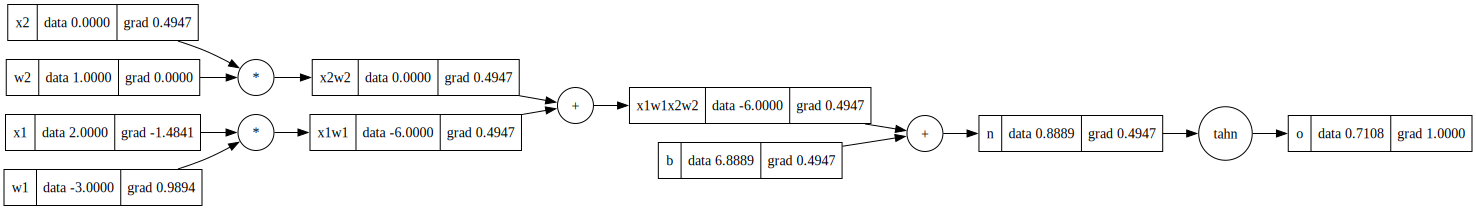

In [21]:
draw_dot(o)

In [22]:
x1 = Value(2.0) ; x1.label= 'x1'
x2 = Value(0.0) ; x2.label= 'x2'
w1 = Value(-3.0) ; w1.label= 'w1'
w2 = Value(1.0) ; w2.label= 'w2'
b = Value(6.888881) ; b.label= 'b'
x1w1 = x1*w1 ; x1w1.label= 'x1w1'
x2w2 = x2*w2 ; x2w2.label= 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label= 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label= 'n'
o= n.tanh() ; o.label= 'o'
o.backward()

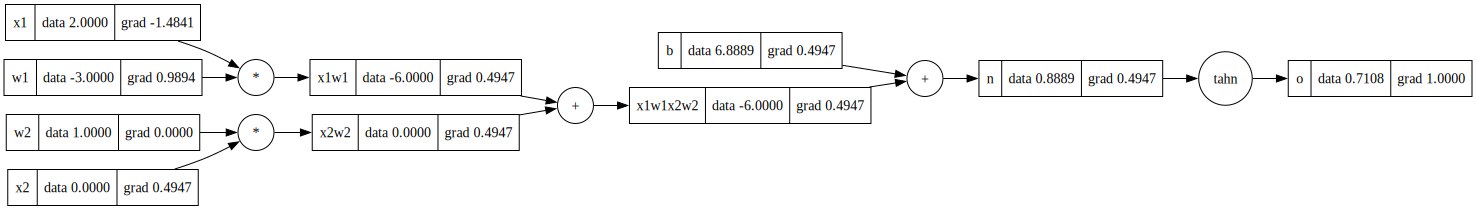

In [23]:
draw_dot(o)

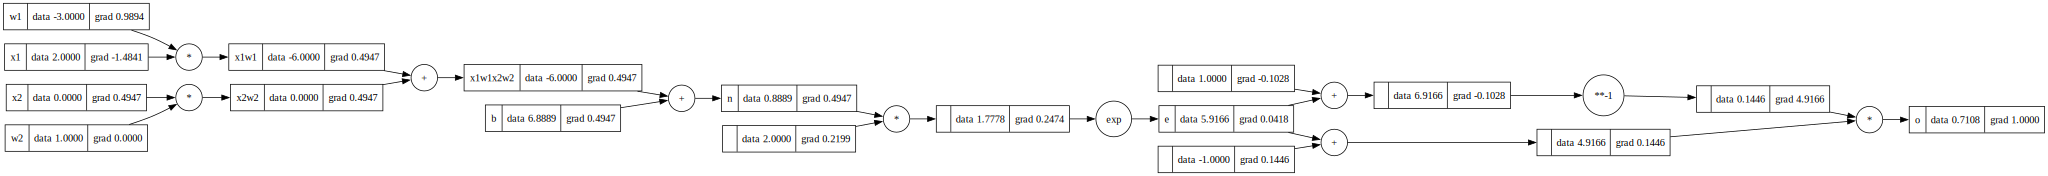

In [24]:
x1 = Value(2.0) ; x1.label= 'x1'
x2 = Value(0.0) ; x2.label= 'x2'
w1 = Value(-3.0) ; w1.label= 'w1'
w2 = Value(1.0) ; w2.label= 'w2'
b = Value(6.888881) ; b.label= 'b'
x1w1 = x1*w1 ; x1w1.label= 'x1w1'
x2w2 = x2*w2 ; x2w2.label= 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label= 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label= 'n'
# o= n.tanh() ; o.label= 'o'
# ----------
e = (2*n).exp(); e.label= 'e'
o = (e-1)/ (e+1); o.label= 'o'
# ----------
o.backward()
draw_dot(o)

In [25]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [26]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
      
  def parameters(self):
    return self.w + [self.b]
      

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
      
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    
      

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
                # Layer(3,4), Layer(4,4), Layer(4,1)
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
      
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
    
  

In [27]:
n = MLP(3, [4, 4, 1])
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 

In [28]:
for k in range(20):
    #feedward oass
    ypred = [n(x) for x in xs]
    loss = sum((yout - yre)**2 for yout,yre in zip(ypred,ys))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #upgrade params
    for p in n.parameters():
        p.data += -0.01* p.grad

    print(f"{k}: {loss.data}")

0: 4.509888687110289
1: 3.813519691258317
2: 3.079394021062405
3: 2.402007250089065
4: 1.8585206424548573
5: 1.465773874711318
6: 1.1944311102305094
7: 1.0055110564667984
8: 0.8689694375333863
9: 0.7656312382358244
10: 0.6840348028947445
11: 0.6173778435085956
12: 0.5615237684513231
13: 0.5138488357385306
14: 0.4726027950624163
15: 0.43655687163482865
16: 0.4048075910066351
17: 0.3766646284734923
18: 0.351584364345512
19: 0.32912878978108334


In [29]:
ypred

[Value(data=0.7846165979594926),
 Value(data=-0.6434564152700045),
 Value(data=-0.7198517527055102),
 Value(data=0.7222727747730692)]

In [35]:
a= Value(2)
b = Value(3)
c = Value(4)

In [37]:
z = a * b + c

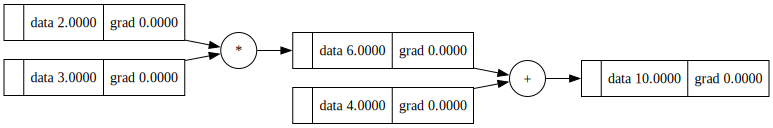

In [38]:
draw_dot(z)

In [39]:
z.backward()

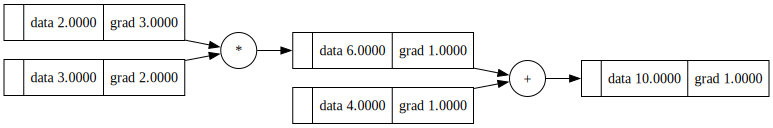

In [40]:
draw_dot(z)

In [ ]:
damnn thats crazy!!